# STAT 306 Project

## Install Libraries
Run this cell if the following cell throws errors.

In [905]:
# install.packages("ggplot2")
# install.packages("leaps")
# install.packages("car")

## Add Libraries

In [906]:
library(ggplot2)
library(leaps)
library(car)

### Load and Preview Data


In [907]:
setwd("/home/jupyter/stat306_group_project/")

In [908]:
df = read.csv("Sleep_Efficiency.csv")
head(df)

,ID,Age,Gender,Bedtime,Wakeup.time,Sleep.duration,Sleep.efficiency,REM.sleep.percentage,Deep.sleep.percentage,Light.sleep.percentage,Awakenings,Caffeine.consumption,Alcohol.consumption,Smoking.status,Exercise.frequency
,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,1,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0,0,0,Yes,3
2,2,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3,0,3,Yes,3
3,3,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1,0,0,No,3
4,4,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3,50,5,Yes,1
5,5,57,Male,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,0.76,27,55,18,3,0,3,No,3
6,6,36,Female,2021-07-01 21:00:00,2021-07-01 04:30:00,7.5,0.90,23,60,17,0,NA,0,No,1


### Preliminary Data Cleaning
Here, we identify and remove NA Cells from the data. 

In [909]:
# identify NAs
na_locations <- which(is.na(df), arr.ind = TRUE)[, 1]
# how many do we have?
print(paste("There are", length(unique(na_locations)), "entries with NAs."))
# subset original dataframe
df1 = df[-unique(na_locations),]

[1] "There are 64 entries with NAs."


Data Cleaning Continued : `Bedtime` and `Wakeup.time` as numeric variables in $[0, 24]$.

In [910]:
df1$Bedtime = as.numeric(format(strptime(df1$Bedtime, format = "%Y-%m-%d %H:%M:%S"), format = "%H"))
df1$Wakeup.time = as.numeric(format(strptime(df1$Wakeup.time, format = "%Y-%m-%d %H:%M:%S"), format = "%H"))

Here, we replace `Smoking.status` with `1` if the person responded "Yes," and `0` otherwise. This is slightly more useful in terms of regression dummy variables.

In [911]:
df1$Smoking.status = as.numeric((df1$Smoking.status) == unique(df1$Smoking.status)[1])

Here, we declare the remaining categorical variables in the model as factors.

In [912]:
# use the factor function to ensure R treats these as categories
df1$Gender = factor(df1$Gender)
df1$Caffeine.consumption = factor(df1$Caffeine.consumption)
df1$Alcohol.consumption = factor(df1$Alcohol.consumption)
df1$Exercise.frequency = factor(df1$Exercise.frequency)

Now, we can preview the levels of each Factor.

In [913]:
levels(df1$Caffeine.consumption)

[1] "0"   "25"  "50"  "75"  "100" "200"

In [914]:
levels(df1$Alcohol.consumption)

[1] "0" "1" "2" "3" "4" "5"

In [915]:
levels(df1$Gender)

[1] "Female" "Male"

In [916]:
levels(df1$Exercise.frequency)

[1] "0" "1" "2" "3" "4" "5"

And, finally, preview the whole dataframe.

In [917]:
# preview
head(df1)

,ID,Age,Gender,Bedtime,Wakeup.time,Sleep.duration,Sleep.efficiency,REM.sleep.percentage,Deep.sleep.percentage,Light.sleep.percentage,Awakenings,Caffeine.consumption,Alcohol.consumption,Smoking.status,Exercise.frequency
,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<fct>,<fct>,<dbl>,<fct>
1,1,65,Female,1,7,6,0.88,18,70,12,0,0,0,1,3
2,2,69,Male,2,9,7,0.66,19,28,53,3,0,3,1,3
3,3,40,Female,21,5,8,0.89,20,70,10,1,0,0,0,3
4,4,40,Female,2,8,6,0.51,23,25,52,3,50,5,1,1
5,5,57,Male,1,9,8,0.76,27,55,18,3,0,3,0,3
7,7,27,Female,21,3,6,0.54,28,25,47,2,50,0,1,1


### Logistic Regression Set-Up
Here, we can define "sleep efficient" as a 0 or 1, indicating whether or not someone is efficient with their sleep. <br>
This metric is used due to the fact that many respondents seemed to have a `0.5` efficiency.

In [918]:
# define boolean vector
sleep_efficicient = df1$Sleep.efficiency < 0.5
# append to data frame
df1 = cbind(df1, sleep_efficicient)

### What Does the Full Model Look Like? (brainstorm)
From these data, we could consider a model in which we take Sleep Efficiency $y$, for $y \in [0,5, 0.99]$ and consider the following explanatory variables.
* `Age`, as $x_1 \in [9, 69] \subset \mathbb{N}$, as a Numeric Variable. There may be interaction with this variable and many others. For example, `Age` is certainly dependant on `Smoking.status` and `Alcohol.consumption`.
* `Bedtime` and `Wakeup.time` define the `Sleep.duration` variable, so there is obviously colinearity there.

My first thoughts on the full model (ignoring interaction terms, of which there will be many). In order of columns we will have.
* Age, Bedtime, WakeupTime, SleepDuration, REMSleepPercentage, DeepSleepPercentage, LightSleepPercentage, Awakenings are **numeric**
* Gender, CaffeineConsumption, SmokingStatus, Exercise.Frequency as categorical variables.
    * Gender has 2 Levels
    * Caffeine Consumption has 6 Levels
    * Alcohol Consumption has 6 Levels
    * Exercise Frequency has 6 Levels

### Separate Data into Train and Test
We'll use two different metrics, 80-20 ratio, which means 80% is training and 20% is testing. We'll may also do a 70-30 split.

In [919]:
set.seed(20071969) # set seed to 20 July, 1969

#### Train and Test Set 1
Here, we put 80% of the data into training and 20% into testing.

In [920]:
# here we find the number corresponding to 80% of the data
len_train1 = ceiling(nrow(df1)*0.80)
# use the sample int functon to get indexes
ss1 = sample.int(nrow(df1), len_train1)
# holdout set
test =  df1[-ss1, ] 
# training set
train = df1[ss1, ] 
# summarize training set
summary(train)

       ID             Age           Gender       Bedtime       Wakeup.time    
 Min.   :  1.0   Min.   : 9.00   Female:155   Min.   : 0.00   Min.   : 3.000  
 1st Qu.:121.5   1st Qu.:29.00   Male  :156   1st Qu.: 1.00   1st Qu.: 5.000  
 Median :231.0   Median :40.00                Median : 2.00   Median : 7.000  
 Mean   :228.4   Mean   :40.87                Mean   :10.72   Mean   : 6.913  
 3rd Qu.:337.0   3rd Qu.:52.00                3rd Qu.:22.00   3rd Qu.: 9.000  
 Max.   :452.0   Max.   :69.00                Max.   :23.00   Max.   :12.000  
 Sleep.duration   Sleep.efficiency REM.sleep.percentage Deep.sleep.percentage
 Min.   : 5.000   Min.   :0.500    Min.   :15.00        Min.   :18.00        
 1st Qu.: 7.000   1st Qu.:0.710    1st Qu.:20.00        1st Qu.:52.00        
 Median : 7.500   Median :0.830    Median :22.00        Median :58.00        
 Mean   : 7.486   Mean   :0.791    Mean   :22.66        Mean   :53.21        
 3rd Qu.: 8.000   3rd Qu.:0.905    3rd Qu.:25.00        3

In [921]:
rem = grep("Sleep.efficiency", colnames(df1))
rem

[1] 7

In [922]:
LDF = df1
# get pre addition length of df1
pre = ncol(df1)
# define keeps list as not the IDs, plus all columns
keeps = c(FALSE, rep(TRUE, times = pre-2), FALSE)
keeps[rem] = FALSE
# for every column name
for (i in colnames(df1)){
        # if the column is one of our factors
        if(class(df1[[i]]) == "factor"){
            # get its location
            loc = as.numeric(grep(i, colnames(df1)))
            # remove it from the list of keeps
            keeps[loc] = FALSE
            # for every level in the factor 
            for (lvl in (levels(df1[[i]]))){
                # define a name for the new exploded column
                name = paste(i, lvl, sep = ".")
                # new column is whether factor is that level (0 or 1)
                newcol = as.numeric((df1[[i]] == lvl))
                # initiate a new column with the name and values
                LDF[name] = newcol
            }
       }  
}
# get change in dataframe length from factor exploding
post = ncol(df1) - pre
# add  new columns to keeps
keepsF = append(keeps, rep(TRUE, times = (post)))
# slice the df1 to exclude factors and include split levels
prDF = LDF[keepsF]
# preview
head(prDF)

,Age,Bedtime,Wakeup.time,Sleep.duration,REM.sleep.percentage,Deep.sleep.percentage,Light.sleep.percentage,Awakenings,Smoking.status,Gender.Male,Caffeine.consumption.25,Caffeine.consumption.50,Caffeine.consumption.75,Caffeine.consumption.200,Alcohol.consumption.0,Alcohol.consumption.1,Alcohol.consumption.2,Alcohol.consumption.5,Exercise.frequency.3,Exercise.frequency.5
,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,65,1,7,6,18,70,12,0,1,0,0,0,0,0,1,0,0,0,1,0
2,69,2,9,7,19,28,53,3,1,1,0,0,0,0,0,0,0,0,1,0
3,40,21,5,8,20,70,10,1,0,0,0,0,0,0,1,0,0,0,1,0
4,40,2,8,6,23,25,52,3,1,0,0,1,0,0,0,0,0,1,0,0
5,57,1,9,8,27,55,18,3,0,1,0,0,0,0,0,0,0,0,1,0
7,27,21,3,6,28,25,47,2,1,0,0,1,0,0,1,0,0,0,0,0


In [923]:
dfPRZ = df1[keeps]
dfPRZ = (dfPRZ[,-c(length(dfPRZ)-1, length(dfPRZ))])
head(dfPRZ)

,Age,Bedtime,Wakeup.time,Sleep.duration,REM.sleep.percentage,Deep.sleep.percentage,Light.sleep.percentage
,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,65,1,7,6,18,70,12
2,69,2,9,7,19,28,53
3,40,21,5,8,20,70,10
4,40,2,8,6,23,25,52
5,57,1,9,8,27,55,18
7,27,21,3,6,28,25,47


In [924]:
# scaled with only numeric non-categoricals
pcaEff_Z = prcomp(dfPRZ, scale = TRUE)
summary(pcaEff_Z)

Importance of components:
                          PC1    PC2    PC3    PC4    PC5     PC6       PC7
Standard deviation     1.4852 1.3476 1.0318 0.9971 0.8983 0.33531 2.933e-16
Proportion of Variance 0.3151 0.2594 0.1521 0.1420 0.1153 0.01606 0.000e+00
Cumulative Proportion  0.3151 0.5746 0.7266 0.8687 0.9839 1.00000 1.000e+00

In [925]:
# not scaled, with exploded categoricals by factor
pcaEff = prcomp(prDF, scale = FALSE)
summary(pcaEff)

Importance of components:
                           PC1     PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     21.7659 13.4427 10.5017 4.19520 1.41600 1.26730 0.60549
Proportion of Variance  0.6014  0.2294  0.1400 0.02234 0.00255 0.00204 0.00047
Cumulative Proportion   0.6014  0.8308  0.9708 0.99319 0.99574 0.99777 0.99824
                           PC8     PC9    PC10    PC11    PC12   PC13   PC14
Standard deviation     0.56557 0.51016 0.43668 0.43011 0.34504 0.2863 0.2838
Proportion of Variance 0.00041 0.00033 0.00024 0.00023 0.00015 0.0001 0.0001
Cumulative Proportion  0.99865 0.99898 0.99922 0.99945 0.99960 0.9997 0.9998
                          PC15    PC16    PC17    PC18    PC19      PC20
Standard deviation     0.26064 0.18684 0.15151 0.12702 0.08545 4.151e-15
Proportion of Variance 0.00009 0.00004 0.00003 0.00002 0.00001 0.000e+00
Cumulative Proportion  0.99990 0.99994 0.99997 0.99999 1.00000 1.000e+00

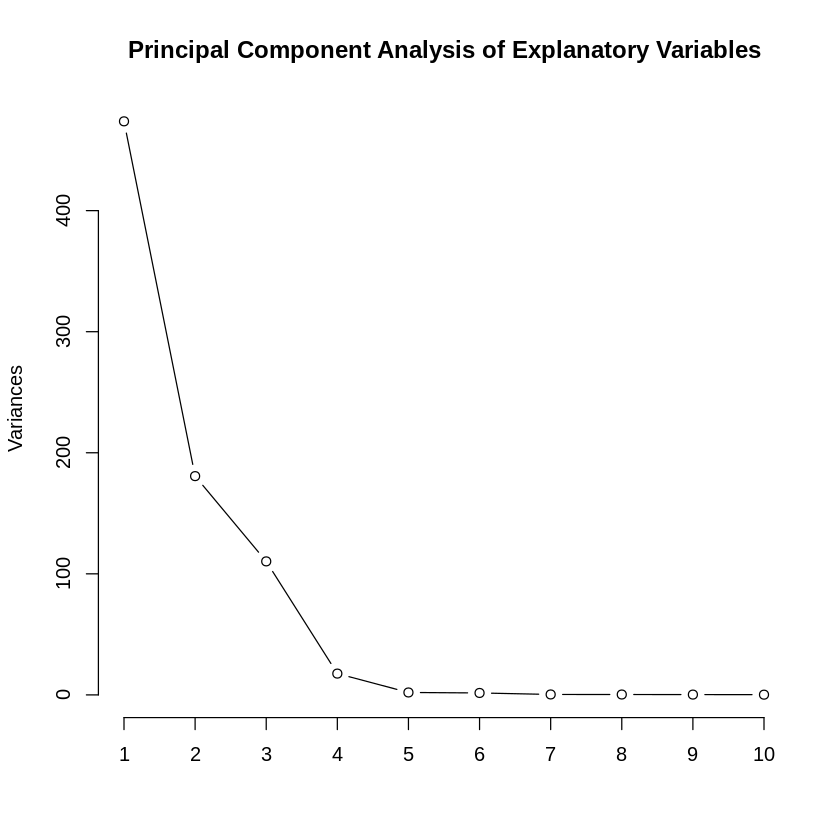

In [926]:
# A biplot of the first two components and the original axes overlaid
screeplot(pcaEff, type = "lines", main = "Principal Component Analysis of Explanatory Variables")

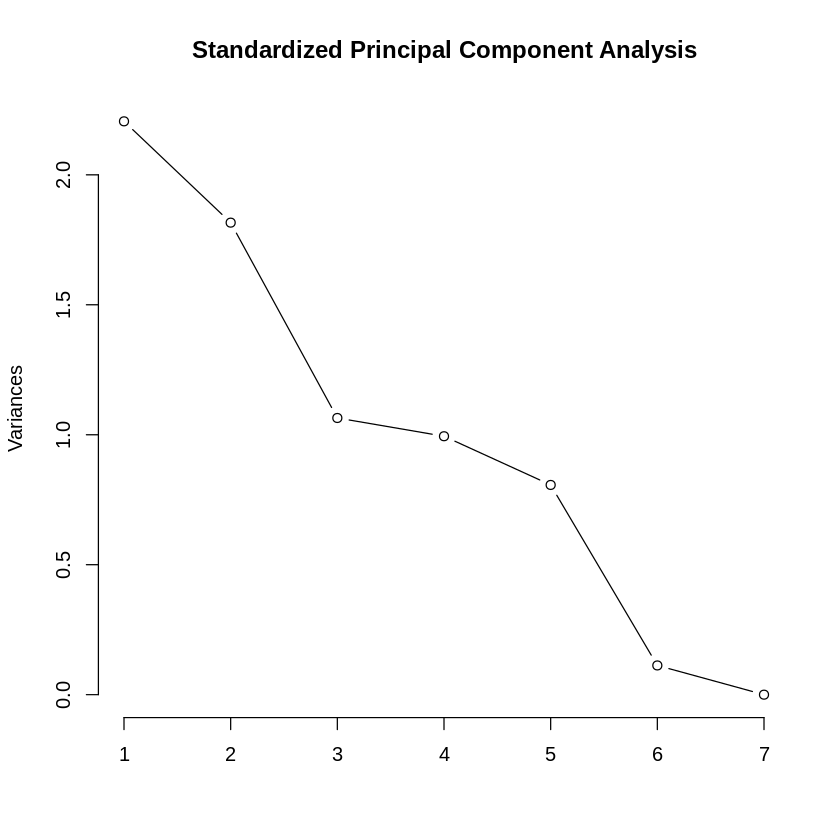

In [927]:
# A biplot of the first two components and the original axes overlaid
screeplot(pcaEff_Z, type = "lines", main = "Standardized Principal Component Analysis")

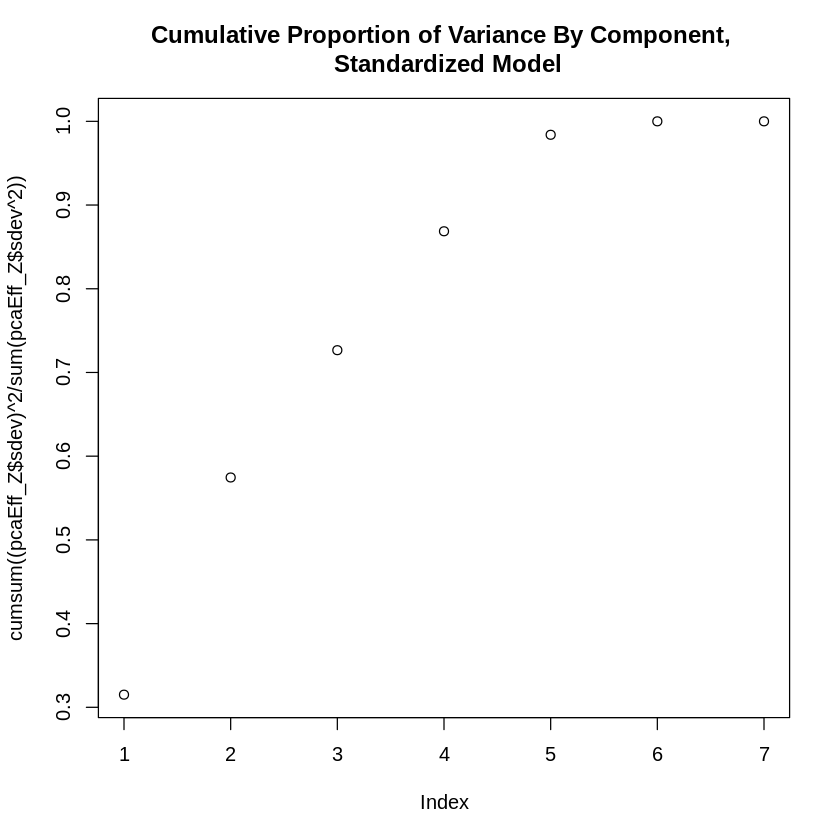

In [928]:
# Calculate proportion of total variance by component
plot(cumsum((pcaEff_Z$sdev)^2 / sum(pcaEff_Z$sdev^2)), main = "Cumulative Proportion of Variance By Component, \n Standardized Model")

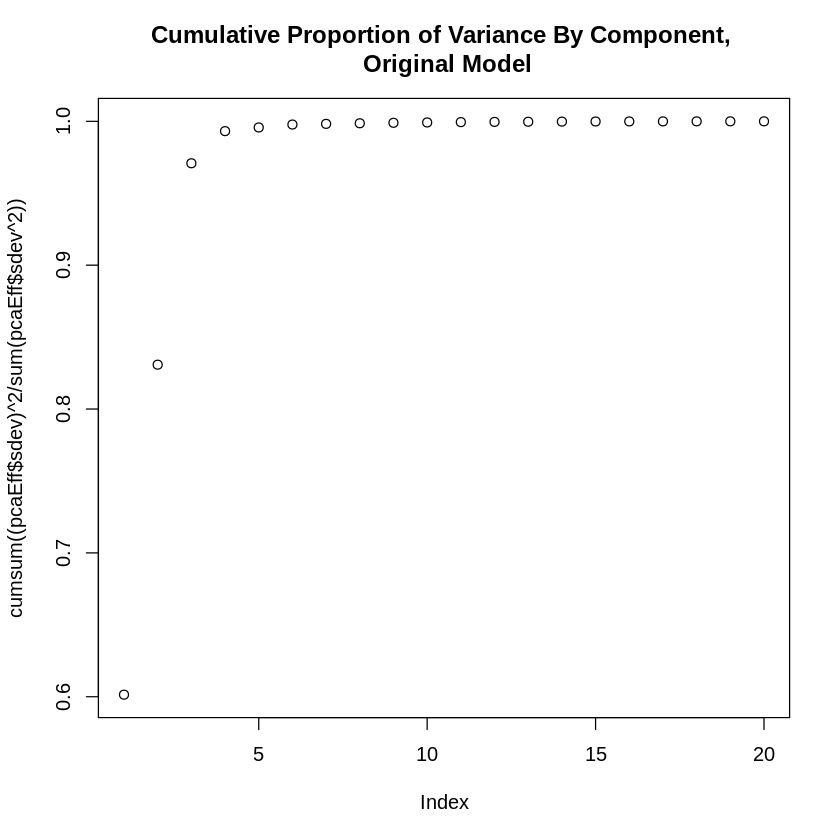

In [929]:
# Calculate proportion of total variance by component
plot(cumsum((pcaEff$sdev)^2 / sum(pcaEff$sdev^2)), main = "Cumulative Proportion of Variance By Component, \n Original Model")

In [930]:
prcomp(dfPRZ, scale = TRUE)

Standard deviations (1, .., p=7):
[1] 1.485201e+00 1.347616e+00 1.031755e+00 9.971307e-01 8.982706e-01
[6] 3.353069e-01 2.932928e-16

Rotation (n x k) = (7 x 7):
                               PC1        PC2          PC3          PC4
Age                    -0.00205427 -0.1294273 -0.753254705 -0.413155498
Bedtime                -0.43500777  0.3791336  0.223570422  0.037517320
Wakeup.time             0.50231159 -0.4580843 -0.004723227 -0.005646384
Sleep.duration          0.30542046 -0.3141986  0.361635640  0.295323336
REM.sleep.percentage    0.02589215  0.1409775 -0.495736477  0.839156054
Deep.sleep.percentage  -0.48070863 -0.5167516  0.054729168  0.002852242
Light.sleep.percentage  0.48312964  0.4940014  0.055416913 -0.190935101
                                PC5          PC6           PC7
Age                     0.492268260 -0.053161990  0.000000e+00
Bedtime                 0.533580330  0.575262303  1.423818e-15
Wakeup.time            -0.051307556  0.731542998 -3.580574e-16
Sleep.dura

In [931]:
prcomp(prDF, scale = FALSE)

Standard deviations (1, .., p=20):
 [1] 2.176594e+01 1.344266e+01 1.050165e+01 4.195199e+00 1.416004e+00
 [6] 1.267304e+00 6.054864e-01 5.655710e-01 5.101615e-01 4.366766e-01
[11] 4.301134e-01 3.450444e-01 2.862615e-01 2.838359e-01 2.606351e-01
[16] 1.868416e-01 1.515099e-01 1.270224e-01 8.544886e-02 4.151014e-15

Rotation (n x k) = (20 x 20):
                                   PC1           PC2           PC3
Age                      -5.759104e-02 -0.9840268093  0.1675163635
Bedtime                  -5.977577e-02  0.1685088262  0.9726665376
Wakeup.time               1.209005e-02 -0.0298261563 -0.1430902135
Sleep.duration            1.806995e-03  0.0026933479 -0.0137089184
REM.sleep.percentage      1.244512e-02 -0.0063063660  0.0013167237
Deep.sleep.percentage    -7.105521e-01  0.0358161875 -0.0501748532
Light.sleep.percentage    6.981070e-01 -0.0295098215  0.0488581295
Awakenings                2.103805e-02 -0.0038731191 -0.0101360784
Smoking.status            4.715231e-03 -0.002096184